In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

tf.keras.backend.clear_session()

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Kr2010.csv', index_col=0)
data_df['sbj'] -= 1

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(3522, 4) (3522, 4)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [8]:
# batch_size = X_train.shape[0]
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, obs_train))
# train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 1s 559ms/step - loss: 21399.9941
Epoch 2/5000
1/1 [==============================] - 0s 3ms/step - loss: 21305.0820
Epoch 3/5000
1/1 [==============================] - 0s 2ms/step - loss: 21235.3066
Epoch 4/5000
1/1 [==============================] - 0s 3ms/step - loss: 21176.2891
Epoch 5/5000
1/1 [==============================] - 0s 3ms/step - loss: 21123.4727
Epoch 6/5000
1/1 [==============================] - 0s 3ms/step - loss: 21074.7188
Epoch 7/5000
1/1 [==============================] - 0s 3ms/step - loss: 21028.8281
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 20985.0645
Epoch 9/5000
1/1 [==============================] - 0s 3ms/step - loss: 20942.9688
Epoch 10/5000
1/1 [==============================] - 0s 3ms/step - loss: 20902.2266
Epoch 11/5000
1/1 [==============================] - 0s 3ms/step - loss: 20862.6211
Epoch 12/5000
1/1 [==============================] - 0s 3ms/step - loss: 20823.9883

1/1 [==============================] - 0s 3ms/step - loss: 18644.6133
Epoch 99/5000
1/1 [==============================] - 0s 3ms/step - loss: 18627.0430
Epoch 100/5000
1/1 [==============================] - 0s 2ms/step - loss: 18609.5762
Epoch 101/5000
1/1 [==============================] - 0s 2ms/step - loss: 18592.2285
Epoch 102/5000
1/1 [==============================] - 0s 3ms/step - loss: 18574.9863
Epoch 103/5000
1/1 [==============================] - 0s 3ms/step - loss: 18557.8535
Epoch 104/5000
1/1 [==============================] - 0s 3ms/step - loss: 18540.8262
Epoch 105/5000
1/1 [==============================] - 0s 2ms/step - loss: 18523.9043
Epoch 106/5000
1/1 [==============================] - 0s 2ms/step - loss: 18507.0859
Epoch 107/5000
1/1 [==============================] - 0s 3ms/step - loss: 18490.3711
Epoch 108/5000
1/1 [==============================] - 0s 3ms/step - loss: 18473.7559
Epoch 109/5000
1/1 [==============================] - 0s 3ms/step - loss: 18457.2

1/1 [==============================] - 0s 3ms/step - loss: 17324.3750
Epoch 195/5000
1/1 [==============================] - 0s 3ms/step - loss: 17313.4297
Epoch 196/5000
1/1 [==============================] - 0s 2ms/step - loss: 17302.5332
Epoch 197/5000
1/1 [==============================] - 0s 3ms/step - loss: 17291.6777
Epoch 198/5000
1/1 [==============================] - 0s 3ms/step - loss: 17280.8594
Epoch 199/5000
1/1 [==============================] - 0s 3ms/step - loss: 17270.0859
Epoch 200/5000
1/1 [==============================] - 0s 2ms/step - loss: 17259.3516
Epoch 201/5000
1/1 [==============================] - 0s 3ms/step - loss: 17248.6582
Epoch 202/5000
1/1 [==============================] - 0s 3ms/step - loss: 17238.0059
Epoch 203/5000
1/1 [==============================] - 0s 3ms/step - loss: 17227.3945
Epoch 204/5000
1/1 [==============================] - 0s 2ms/step - loss: 17216.8184
Epoch 205/5000
1/1 [==============================] - 0s 3ms/step - loss: 17206.

1/1 [==============================] - 0s 3ms/step - loss: 16427.4121
Epoch 291/5000
1/1 [==============================] - 0s 3ms/step - loss: 16419.3516
Epoch 292/5000
1/1 [==============================] - 0s 2ms/step - loss: 16411.3125
Epoch 293/5000
1/1 [==============================] - 0s 2ms/step - loss: 16403.2930
Epoch 294/5000
1/1 [==============================] - 0s 3ms/step - loss: 16395.2891
Epoch 295/5000
1/1 [==============================] - 0s 3ms/step - loss: 16387.3047
Epoch 296/5000
1/1 [==============================] - 0s 2ms/step - loss: 16379.3389
Epoch 297/5000
1/1 [==============================] - 0s 2ms/step - loss: 16371.3877
Epoch 298/5000
1/1 [==============================] - 0s 2ms/step - loss: 16363.4590
Epoch 299/5000
1/1 [==============================] - 0s 2ms/step - loss: 16355.5430
Epoch 300/5000
1/1 [==============================] - 0s 3ms/step - loss: 16347.6436
Epoch 301/5000
1/1 [==============================] - 0s 2ms/step - loss: 16339.

1/1 [==============================] - 0s 2ms/step - loss: 15698.7178
Epoch 387/5000
1/1 [==============================] - 0s 2ms/step - loss: 15690.1895
Epoch 388/5000
1/1 [==============================] - 0s 3ms/step - loss: 15681.6074
Epoch 389/5000
1/1 [==============================] - 0s 3ms/step - loss: 15672.9697
Epoch 390/5000
1/1 [==============================] - 0s 3ms/step - loss: 15664.2656
Epoch 391/5000
1/1 [==============================] - 0s 2ms/step - loss: 15655.4873
Epoch 392/5000
1/1 [==============================] - 0s 3ms/step - loss: 15646.6289
Epoch 393/5000
1/1 [==============================] - 0s 3ms/step - loss: 15637.6865
Epoch 394/5000
1/1 [==============================] - 0s 2ms/step - loss: 15628.6523
Epoch 395/5000
1/1 [==============================] - 0s 3ms/step - loss: 15619.5273
Epoch 396/5000
1/1 [==============================] - 0s 2ms/step - loss: 15610.3125
Epoch 397/5000
1/1 [==============================] - 0s 2ms/step - loss: 15601.

1/1 [==============================] - 0s 2ms/step - loss: 14815.1562
Epoch 483/5000
1/1 [==============================] - 0s 2ms/step - loss: 14806.6152
Epoch 484/5000
1/1 [==============================] - 0s 2ms/step - loss: 14798.0811
Epoch 485/5000
1/1 [==============================] - 0s 2ms/step - loss: 14789.5498
Epoch 486/5000
1/1 [==============================] - 0s 3ms/step - loss: 14781.0293
Epoch 487/5000
1/1 [==============================] - 0s 3ms/step - loss: 14772.5127
Epoch 488/5000
1/1 [==============================] - 0s 2ms/step - loss: 14764.0029
Epoch 489/5000
1/1 [==============================] - 0s 2ms/step - loss: 14755.5264
Epoch 490/5000
1/1 [==============================] - 0s 2ms/step - loss: 14747.1143
Epoch 491/5000
1/1 [==============================] - 0s 3ms/step - loss: 14738.6904
Epoch 492/5000
1/1 [==============================] - 0s 3ms/step - loss: 14730.2295
Epoch 493/5000
1/1 [==============================] - 0s 2ms/step - loss: 14721.

1/1 [==============================] - 0s 2ms/step - loss: 14040.0303
Epoch 579/5000
1/1 [==============================] - 0s 2ms/step - loss: 14032.2480
Epoch 580/5000
1/1 [==============================] - 0s 3ms/step - loss: 14024.4727
Epoch 581/5000
1/1 [==============================] - 0s 2ms/step - loss: 14016.6973
Epoch 582/5000
1/1 [==============================] - 0s 2ms/step - loss: 14008.9287
Epoch 583/5000
1/1 [==============================] - 0s 2ms/step - loss: 14001.1582
Epoch 584/5000
1/1 [==============================] - 0s 2ms/step - loss: 13993.3984
Epoch 585/5000
1/1 [==============================] - 0s 3ms/step - loss: 13985.6367
Epoch 586/5000
1/1 [==============================] - 0s 3ms/step - loss: 13977.8799
Epoch 587/5000
1/1 [==============================] - 0s 2ms/step - loss: 13970.1250
Epoch 588/5000
1/1 [==============================] - 0s 2ms/step - loss: 13962.3750
Epoch 589/5000
1/1 [==============================] - 0s 3ms/step - loss: 13954.

1/1 [==============================] - 0s 3ms/step - loss: 13308.7275
Epoch 675/5000
1/1 [==============================] - 0s 2ms/step - loss: 13301.2812
Epoch 676/5000
1/1 [==============================] - 0s 2ms/step - loss: 13293.8545
Epoch 677/5000
1/1 [==============================] - 0s 2ms/step - loss: 13286.4170
Epoch 678/5000
1/1 [==============================] - 0s 2ms/step - loss: 13279.0020
Epoch 679/5000
1/1 [==============================] - 0s 3ms/step - loss: 13271.5693
Epoch 680/5000
1/1 [==============================] - 0s 3ms/step - loss: 13264.1602
Epoch 681/5000
1/1 [==============================] - 0s 2ms/step - loss: 13256.7373
Epoch 682/5000
1/1 [==============================] - 0s 2ms/step - loss: 13249.3369
Epoch 683/5000
1/1 [==============================] - 0s 2ms/step - loss: 13241.9189
Epoch 684/5000
1/1 [==============================] - 0s 2ms/step - loss: 13234.5254
Epoch 685/5000
1/1 [==============================] - 0s 3ms/step - loss: 13227.

1/1 [==============================] - 0s 3ms/step - loss: 12606.4648
Epoch 771/5000
1/1 [==============================] - 0s 3ms/step - loss: 12599.2266
Epoch 772/5000
1/1 [==============================] - 0s 3ms/step - loss: 12591.9980
Epoch 773/5000
1/1 [==============================] - 0s 2ms/step - loss: 12584.7607
Epoch 774/5000
1/1 [==============================] - 0s 2ms/step - loss: 12577.5312
Epoch 775/5000
1/1 [==============================] - 0s 2ms/step - loss: 12570.3008
Epoch 776/5000
1/1 [==============================] - 0s 3ms/step - loss: 12563.0732
Epoch 777/5000
1/1 [==============================] - 0s 2ms/step - loss: 12555.8438
Epoch 778/5000
1/1 [==============================] - 0s 2ms/step - loss: 12548.6191
Epoch 779/5000
1/1 [==============================] - 0s 2ms/step - loss: 12541.3896
Epoch 780/5000
1/1 [==============================] - 0s 2ms/step - loss: 12534.1699
Epoch 781/5000
1/1 [==============================] - 0s 3ms/step - loss: 12526.

1/1 [==============================] - 0s 2ms/step - loss: 11926.7607
Epoch 867/5000
1/1 [==============================] - 0s 3ms/step - loss: 11919.9121
Epoch 868/5000
1/1 [==============================] - 0s 3ms/step - loss: 11913.1162
Epoch 869/5000
1/1 [==============================] - 0s 2ms/step - loss: 11906.2842
Epoch 870/5000
1/1 [==============================] - 0s 2ms/step - loss: 11899.5039
Epoch 871/5000
1/1 [==============================] - 0s 2ms/step - loss: 11892.6846
Epoch 872/5000
1/1 [==============================] - 0s 2ms/step - loss: 11885.9229
Epoch 873/5000
1/1 [==============================] - 0s 3ms/step - loss: 11879.1162
Epoch 874/5000
1/1 [==============================] - 0s 2ms/step - loss: 11872.3740
Epoch 875/5000
1/1 [==============================] - 0s 2ms/step - loss: 11865.5820
Epoch 876/5000
1/1 [==============================] - 0s 2ms/step - loss: 11858.8584
Epoch 877/5000
1/1 [==============================] - 0s 2ms/step - loss: 11852.

1/1 [==============================] - 0s 2ms/step - loss: 11321.1211
Epoch 963/5000
1/1 [==============================] - 0s 3ms/step - loss: 11315.3545
Epoch 964/5000
1/1 [==============================] - 0s 2ms/step - loss: 11309.6787
Epoch 965/5000
1/1 [==============================] - 0s 2ms/step - loss: 11303.9346
Epoch 966/5000
1/1 [==============================] - 0s 2ms/step - loss: 11298.2812
Epoch 967/5000
1/1 [==============================] - 0s 2ms/step - loss: 11292.5596
Epoch 968/5000
1/1 [==============================] - 0s 2ms/step - loss: 11286.9326
Epoch 969/5000
1/1 [==============================] - 0s 3ms/step - loss: 11281.2354
Epoch 970/5000
1/1 [==============================] - 0s 3ms/step - loss: 11275.6328
Epoch 971/5000
1/1 [==============================] - 0s 3ms/step - loss: 11269.9590
Epoch 972/5000
1/1 [==============================] - 0s 2ms/step - loss: 11264.3848
Epoch 973/5000
1/1 [==============================] - 0s 2ms/step - loss: 11258.

1/1 [==============================] - 0s 3ms/step - loss: 10845.7031
Epoch 1058/5000
1/1 [==============================] - 0s 3ms/step - loss: 10841.5586
Epoch 1059/5000
1/1 [==============================] - 0s 2ms/step - loss: 10837.2822
Epoch 1060/5000
1/1 [==============================] - 0s 2ms/step - loss: 10833.1748
Epoch 1061/5000
1/1 [==============================] - 0s 2ms/step - loss: 10828.9346
Epoch 1062/5000
1/1 [==============================] - 0s 2ms/step - loss: 10824.8613
Epoch 1063/5000
1/1 [==============================] - 0s 3ms/step - loss: 10820.6592
Epoch 1064/5000
1/1 [==============================] - 0s 3ms/step - loss: 10816.6191
Epoch 1065/5000
1/1 [==============================] - 0s 2ms/step - loss: 10812.4590
Epoch 1066/5000
1/1 [==============================] - 0s 3ms/step - loss: 10808.4521
Epoch 1067/5000
1/1 [==============================] - 0s 2ms/step - loss: 10804.3291
Epoch 1068/5000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10512.1514
Epoch 1153/5000
1/1 [==============================] - 0s 2ms/step - loss: 10509.1836
Epoch 1154/5000
1/1 [==============================] - 0s 3ms/step - loss: 10506.3047
Epoch 1155/5000
1/1 [==============================] - 0s 2ms/step - loss: 10503.3633
Epoch 1156/5000
1/1 [==============================] - 0s 2ms/step - loss: 10500.5029
Epoch 1157/5000
1/1 [==============================] - 0s 3ms/step - loss: 10497.5840
Epoch 1158/5000
1/1 [==============================] - 0s 3ms/step - loss: 10494.7500
Epoch 1159/5000
1/1 [==============================] - 0s 2ms/step - loss: 10491.8496
Epoch 1160/5000
1/1 [==============================] - 0s 3ms/step - loss: 10489.0371
Epoch 1161/5000
1/1 [==============================] - 0s 2ms/step - loss: 10486.1562
Epoch 1162/5000
1/1 [==============================] - 0s 3ms/step - loss: 10483.3604
Epoch 1163/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10275.2686
Epoch 1248/5000
1/1 [==============================] - 0s 3ms/step - loss: 10273.1611
Epoch 1249/5000
1/1 [==============================] - 0s 2ms/step - loss: 10271.0713
Epoch 1250/5000
1/1 [==============================] - 0s 2ms/step - loss: 10268.9736
Epoch 1251/5000
1/1 [==============================] - 0s 2ms/step - loss: 10266.9033
Epoch 1252/5000
1/1 [==============================] - 0s 3ms/step - loss: 10264.8193
Epoch 1253/5000
1/1 [==============================] - 0s 3ms/step - loss: 10262.7637
Epoch 1254/5000
1/1 [==============================] - 0s 3ms/step - loss: 10260.6924
Epoch 1255/5000
1/1 [==============================] - 0s 2ms/step - loss: 10258.6562
Epoch 1256/5000
1/1 [==============================] - 0s 2ms/step - loss: 10256.5986
Epoch 1257/5000
1/1 [==============================] - 0s 2ms/step - loss: 10254.5732
Epoch 1258/5000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10105.9375
Epoch 1343/5000
1/1 [==============================] - 0s 2ms/step - loss: 10104.4932
Epoch 1344/5000
1/1 [==============================] - 0s 3ms/step - loss: 10102.9941
Epoch 1345/5000
1/1 [==============================] - 0s 3ms/step - loss: 10101.5762
Epoch 1346/5000
1/1 [==============================] - 0s 2ms/step - loss: 10100.0850
Epoch 1347/5000
1/1 [==============================] - 0s 3ms/step - loss: 10098.6699
Epoch 1348/5000
1/1 [==============================] - 0s 2ms/step - loss: 10097.1895
Epoch 1349/5000
1/1 [==============================] - 0s 2ms/step - loss: 10095.7881
Epoch 1350/5000
1/1 [==============================] - 0s 3ms/step - loss: 10094.3154
Epoch 1351/5000
1/1 [==============================] - 0s 2ms/step - loss: 10092.9297
Epoch 1352/5000
1/1 [==============================] - 0s 2ms/step - loss: 10091.4707
Epoch 1353/5000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 9987.8350
Epoch 1438/5000
1/1 [==============================] - 0s 2ms/step - loss: 9986.7520
Epoch 1439/5000
1/1 [==============================] - 0s 3ms/step - loss: 9985.7646
Epoch 1440/5000
1/1 [==============================] - 0s 3ms/step - loss: 9984.6777
Epoch 1441/5000
1/1 [==============================] - 0s 3ms/step - loss: 9983.6475
Epoch 1442/5000
1/1 [==============================] - 0s 2ms/step - loss: 9982.6016
Epoch 1443/5000
1/1 [==============================] - 0s 2ms/step - loss: 9981.6016
Epoch 1444/5000
1/1 [==============================] - 0s 2ms/step - loss: 9980.5547
Epoch 1445/5000
1/1 [==============================] - 0s 3ms/step - loss: 9979.5557
Epoch 1446/5000
1/1 [==============================] - 0s 3ms/step - loss: 9978.5020
Epoch 1447/5000
1/1 [==============================] - 0s 2ms/step - loss: 9977.5303
Epoch 1448/5000
1/1 [==============================] - 0s 2ms/step - loss: 9976.4

1/1 [==============================] - 0s 3ms/step - loss: 9900.9570
Epoch 1534/5000
1/1 [==============================] - 0s 2ms/step - loss: 9900.1299
Epoch 1535/5000
1/1 [==============================] - 0s 2ms/step - loss: 9899.3564
Epoch 1536/5000
1/1 [==============================] - 0s 2ms/step - loss: 9898.5850
Epoch 1537/5000
1/1 [==============================] - 0s 2ms/step - loss: 9897.8633
Epoch 1538/5000
1/1 [==============================] - 0s 3ms/step - loss: 9897.0410
Epoch 1539/5000
1/1 [==============================] - 0s 3ms/step - loss: 9896.3096
Epoch 1540/5000
1/1 [==============================] - 0s 2ms/step - loss: 9895.5000
Epoch 1541/5000
1/1 [==============================] - 0s 3ms/step - loss: 9894.7666
Epoch 1542/5000
1/1 [==============================] - 0s 3ms/step - loss: 9893.9580
Epoch 1543/5000
1/1 [==============================] - 0s 3ms/step - loss: 9893.2568
Epoch 1544/5000
1/1 [==============================] - 0s 3ms/step - loss: 9892.4

1/1 [==============================] - 0s 3ms/step - loss: 9834.7295
Epoch 1630/5000
1/1 [==============================] - 0s 2ms/step - loss: 9834.0654
Epoch 1631/5000
1/1 [==============================] - 0s 2ms/step - loss: 9833.6309
Epoch 1632/5000
1/1 [==============================] - 0s 2ms/step - loss: 9832.9619
Epoch 1633/5000
1/1 [==============================] - 0s 2ms/step - loss: 9832.1650
Epoch 1634/5000
1/1 [==============================] - 0s 2ms/step - loss: 9831.6143
Epoch 1635/5000
1/1 [==============================] - 0s 3ms/step - loss: 9831.0078
Epoch 1636/5000
1/1 [==============================] - 0s 2ms/step - loss: 9830.4111
Epoch 1637/5000
1/1 [==============================] - 0s 2ms/step - loss: 9829.7539
Epoch 1638/5000
1/1 [==============================] - 0s 2ms/step - loss: 9829.0986
Epoch 1639/5000
1/1 [==============================] - 0s 2ms/step - loss: 9828.6572
Epoch 1640/5000
1/1 [==============================] - 0s 3ms/step - loss: 9827.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 3ms/step - loss: 9700.1953
Epoch 1915/5000
1/1 [==============================] - 0s 2ms/step - loss: 9699.2500
Epoch 1916/5000
1/1 [==============================] - 0s 3ms/step - loss: 9698.1611
Epoch 1917/5000
1/1 [==============================] - 0s 3ms/step - loss: 9697.3545
Epoch 1918/5000
1/1 [==============================] - 0s 3ms/step - loss: 9697.0732
Epoch 1919/5000
1/1 [==============================] - 0s 3ms/step - loss: 9697.9346
Epoch 1920/5000
1/1 [==============================] - 0s 3ms/step - loss: 9696.4268
Epoch 1921/5000
1/1 [==============================] - 0s 3ms/step - loss: 9696.8193
Epoch 1922/5000
1/1 [==============================] - 0s 3ms/step - loss: 9696.1035
Epoch 1923/5000
1/1 [==============================] - 0s 3ms/step - loss: 9695.7627
Epoch 1924/5000
1/1 [==============================] - 0s 2ms/step - loss: 9694.3828
Epoch 1925/5000
1/1 [==============================] - 0s 3ms/step - loss: 9694.9

1/1 [==============================] - 0s 3ms/step - loss: 9664.8154
Epoch 2011/5000
1/1 [==============================] - 0s 3ms/step - loss: 9664.9600
Epoch 2012/5000
1/1 [==============================] - 0s 3ms/step - loss: 9665.8418
Epoch 2013/5000
1/1 [==============================] - 0s 4ms/step - loss: 9664.9727
Epoch 2014/5000
1/1 [==============================] - 0s 3ms/step - loss: 9665.1621
Epoch 2015/5000
1/1 [==============================] - 0s 3ms/step - loss: 9664.6191
Epoch 2016/5000
1/1 [==============================] - 0s 3ms/step - loss: 9665.1338
Epoch 2017/5000
1/1 [==============================] - 0s 3ms/step - loss: 9664.2490
Epoch 2018/5000
1/1 [==============================] - 0s 4ms/step - loss: 9663.9453
Epoch 2019/5000
1/1 [==============================] - 0s 3ms/step - loss: 9664.2012
Epoch 2020/5000
1/1 [==============================] - 0s 3ms/step - loss: 9664.0166
Epoch 2021/5000
1/1 [==============================] - 0s 3ms/step - loss: 9663.0

1/1 [==============================] - 0s 3ms/step - loss: 9639.8408
Epoch 2107/5000
1/1 [==============================] - 0s 2ms/step - loss: 9635.8945
Epoch 2108/5000
1/1 [==============================] - 0s 4ms/step - loss: 9637.5791
Epoch 2109/5000
1/1 [==============================] - 0s 3ms/step - loss: 9638.8721
Epoch 2110/5000
1/1 [==============================] - 0s 3ms/step - loss: 9639.1377
Epoch 2111/5000
1/1 [==============================] - 0s 2ms/step - loss: 9639.3145
Epoch 2112/5000
1/1 [==============================] - 0s 3ms/step - loss: 9638.8428
Epoch 2113/5000
1/1 [==============================] - 0s 3ms/step - loss: 9637.2627
Epoch 2114/5000
1/1 [==============================] - 0s 3ms/step - loss: 9636.1611
Epoch 2115/5000
1/1 [==============================] - 0s 3ms/step - loss: 9634.6162
Epoch 2116/5000
1/1 [==============================] - 0s 3ms/step - loss: 9633.7266
Epoch 2117/5000
1/1 [==============================] - 0s 2ms/step - loss: 9634.8

1/1 [==============================] - 0s 3ms/step - loss: 9620.8623
Epoch 2203/5000
1/1 [==============================] - 0s 3ms/step - loss: 9616.2119
Epoch 2204/5000
1/1 [==============================] - 0s 3ms/step - loss: 9613.0498
Epoch 2205/5000
1/1 [==============================] - 0s 3ms/step - loss: 9612.3115
Epoch 2206/5000
1/1 [==============================] - 0s 3ms/step - loss: 9610.8701
Epoch 2207/5000
1/1 [==============================] - 0s 3ms/step - loss: 9611.4707
Epoch 2208/5000
1/1 [==============================] - 0s 3ms/step - loss: 9613.8438
Epoch 2209/5000
1/1 [==============================] - 0s 4ms/step - loss: 9610.6660
Epoch 2210/5000
1/1 [==============================] - 0s 3ms/step - loss: 9610.1533
Epoch 2211/5000
1/1 [==============================] - 0s 3ms/step - loss: 9611.8857
Epoch 2212/5000
1/1 [==============================] - 0s 3ms/step - loss: 9612.5225
Epoch 2213/5000
1/1 [==============================] - 0s 3ms/step - loss: 9616.8

1/1 [==============================] - 0s 2ms/step - loss: 9593.6904
Epoch 2299/5000
1/1 [==============================] - 0s 3ms/step - loss: 9594.7324
Epoch 2300/5000
1/1 [==============================] - 0s 3ms/step - loss: 9594.1211
Epoch 2301/5000
1/1 [==============================] - 0s 3ms/step - loss: 9595.6445
Epoch 2302/5000
1/1 [==============================] - 0s 3ms/step - loss: 9593.7842
Epoch 2303/5000
1/1 [==============================] - 0s 3ms/step - loss: 9592.4297
Epoch 2304/5000
1/1 [==============================] - 0s 3ms/step - loss: 9593.3018
Epoch 2305/5000
1/1 [==============================] - 0s 3ms/step - loss: 9593.1846
Epoch 2306/5000
1/1 [==============================] - 0s 3ms/step - loss: 9590.0010
Epoch 2307/5000
1/1 [==============================] - 0s 3ms/step - loss: 9592.4795
Epoch 2308/5000
1/1 [==============================] - 0s 3ms/step - loss: 9593.8184
Epoch 2309/5000
1/1 [==============================] - 0s 2ms/step - loss: 9591.6

1/1 [==============================] - 0s 3ms/step - loss: 9583.5010
Epoch 2395/5000
1/1 [==============================] - 0s 2ms/step - loss: 9575.2100
Epoch 2396/5000
1/1 [==============================] - 0s 3ms/step - loss: 9575.9609
Epoch 2397/5000
1/1 [==============================] - 0s 3ms/step - loss: 9578.6230
Epoch 2398/5000
1/1 [==============================] - 0s 3ms/step - loss: 9578.9590
Epoch 2399/5000
1/1 [==============================] - 0s 3ms/step - loss: 9579.4775
Epoch 2400/5000
1/1 [==============================] - 0s 3ms/step - loss: 9579.7998
Epoch 2401/5000
1/1 [==============================] - 0s 4ms/step - loss: 9578.6592
Epoch 2402/5000
1/1 [==============================] - 0s 3ms/step - loss: 9577.5977
Epoch 2403/5000
1/1 [==============================] - 0s 3ms/step - loss: 9577.5098
Epoch 2404/5000
1/1 [==============================] - 0s 3ms/step - loss: 9574.9922
Epoch 2405/5000
1/1 [==============================] - 0s 2ms/step - loss: 9576.4

1/1 [==============================] - 0s 2ms/step - loss: 9561.7900
Epoch 2491/5000
1/1 [==============================] - 0s 2ms/step - loss: 9560.0889
Epoch 2492/5000
1/1 [==============================] - 0s 3ms/step - loss: 9560.2988
Epoch 2493/5000
1/1 [==============================] - 0s 2ms/step - loss: 9562.8701
Epoch 2494/5000
1/1 [==============================] - 0s 2ms/step - loss: 9565.8516
Epoch 2495/5000
1/1 [==============================] - 0s 3ms/step - loss: 9569.7432
Epoch 2496/5000
1/1 [==============================] - 0s 2ms/step - loss: 9568.6875
Epoch 2497/5000
1/1 [==============================] - 0s 2ms/step - loss: 9564.1387
Epoch 2498/5000
1/1 [==============================] - 0s 3ms/step - loss: 9561.6768
Epoch 2499/5000
1/1 [==============================] - 0s 2ms/step - loss: 9560.1680
Epoch 2500/5000
1/1 [==============================] - 0s 2ms/step - loss: 9558.3721
Epoch 2501/5000
1/1 [==============================] - 0s 3ms/step - loss: 9559.1

1/1 [==============================] - 0s 7ms/step - loss: 9548.2285
Epoch 2587/5000
1/1 [==============================] - 0s 4ms/step - loss: 9549.4990
Epoch 2588/5000
1/1 [==============================] - 0s 3ms/step - loss: 9548.6787
Epoch 2589/5000
1/1 [==============================] - 0s 3ms/step - loss: 9548.5664
Epoch 2590/5000
1/1 [==============================] - 0s 2ms/step - loss: 9549.1455
Epoch 2591/5000
1/1 [==============================] - 0s 3ms/step - loss: 9550.0674
Epoch 2592/5000
1/1 [==============================] - 0s 2ms/step - loss: 9552.0400
Epoch 2593/5000
1/1 [==============================] - 0s 2ms/step - loss: 9551.2266
Epoch 2594/5000
1/1 [==============================] - 0s 3ms/step - loss: 9551.3506
Epoch 2595/5000
1/1 [==============================] - 0s 3ms/step - loss: 9606.6221
Epoch 2596/5000
1/1 [==============================] - 0s 2ms/step - loss: 9551.4375
Epoch 2597/5000
1/1 [==============================] - 0s 3ms/step - loss: 9551.0

1/1 [==============================] - 0s 2ms/step - loss: 9536.6982
Epoch 2683/5000
1/1 [==============================] - 0s 2ms/step - loss: 9539.4268
Epoch 2684/5000
1/1 [==============================] - 0s 3ms/step - loss: 9536.1934
Epoch 2685/5000
1/1 [==============================] - 0s 3ms/step - loss: 9536.8027
Epoch 2686/5000
1/1 [==============================] - 0s 2ms/step - loss: 9548.6416
Epoch 2687/5000
1/1 [==============================] - 0s 2ms/step - loss: 9585.5273
Epoch 2688/5000
1/1 [==============================] - 0s 2ms/step - loss: 9546.3789
Epoch 2689/5000
1/1 [==============================] - 0s 2ms/step - loss: 9537.5010
Epoch 2690/5000
1/1 [==============================] - 0s 3ms/step - loss: 9537.2129
Epoch 2691/5000
1/1 [==============================] - 0s 3ms/step - loss: 9536.2412
Epoch 2692/5000
1/1 [==============================] - 0s 3ms/step - loss: 9535.3008
Epoch 2693/5000
1/1 [==============================] - 0s 2ms/step - loss: 9536.3

1/1 [==============================] - 0s 2ms/step - loss: 9533.8262
Epoch 2779/5000
1/1 [==============================] - 0s 3ms/step - loss: 9535.7451
Epoch 2780/5000
1/1 [==============================] - 0s 3ms/step - loss: 9530.1016
Epoch 2781/5000
1/1 [==============================] - 0s 2ms/step - loss: 9528.9727
Epoch 2782/5000
1/1 [==============================] - 0s 2ms/step - loss: 9529.4902
Epoch 2783/5000
1/1 [==============================] - 0s 2ms/step - loss: 9531.4072
Epoch 2784/5000
1/1 [==============================] - 0s 2ms/step - loss: 9529.3857
Epoch 2785/5000
1/1 [==============================] - 0s 3ms/step - loss: 9529.3457
Epoch 2786/5000
1/1 [==============================] - 0s 3ms/step - loss: 9525.8125
Epoch 2787/5000
1/1 [==============================] - 0s 2ms/step - loss: 9527.8750
Epoch 2788/5000
1/1 [==============================] - 0s 2ms/step - loss: 9527.0107
Epoch 2789/5000
1/1 [==============================] - 0s 2ms/step - loss: 9585.5

1/1 [==============================] - 0s 2ms/step - loss: 9522.2393
Epoch 2875/5000
1/1 [==============================] - 0s 3ms/step - loss: 9519.1338
Epoch 2876/5000
1/1 [==============================] - 0s 3ms/step - loss: 9520.0107
Epoch 2877/5000
1/1 [==============================] - 0s 2ms/step - loss: 9527.5830
Epoch 2878/5000
1/1 [==============================] - 0s 2ms/step - loss: 9534.9131
Epoch 2879/5000
1/1 [==============================] - 0s 2ms/step - loss: 9522.1855
Epoch 2880/5000
1/1 [==============================] - 0s 2ms/step - loss: 9518.7041
Epoch 2881/5000
1/1 [==============================] - 0s 2ms/step - loss: 9519.2891
Epoch 2882/5000
1/1 [==============================] - 0s 2ms/step - loss: 9517.3857
Epoch 2883/5000
1/1 [==============================] - 0s 2ms/step - loss: 9515.1465
Epoch 2884/5000
1/1 [==============================] - 0s 2ms/step - loss: 9513.6035
Epoch 2885/5000
1/1 [==============================] - 0s 3ms/step - loss: 9515.9

1/1 [==============================] - 0s 3ms/step - loss: 9516.1445
Epoch 2971/5000
1/1 [==============================] - 0s 3ms/step - loss: 9508.9883
Epoch 2972/5000
1/1 [==============================] - 0s 2ms/step - loss: 9514.0146
Epoch 2973/5000
1/1 [==============================] - 0s 2ms/step - loss: 9510.6064
Epoch 2974/5000
1/1 [==============================] - 0s 2ms/step - loss: 9510.5684
Epoch 2975/5000
1/1 [==============================] - 0s 3ms/step - loss: 9507.9736
Epoch 2976/5000
1/1 [==============================] - 0s 3ms/step - loss: 9508.8359
Epoch 2977/5000
1/1 [==============================] - 0s 2ms/step - loss: 9510.3223
Epoch 2978/5000
1/1 [==============================] - 0s 2ms/step - loss: 9509.8369
Epoch 2979/5000
1/1 [==============================] - 0s 2ms/step - loss: 9513.3633
Epoch 2980/5000
1/1 [==============================] - 0s 2ms/step - loss: 9515.2812
Epoch 2981/5000
1/1 [==============================] - 0s 3ms/step - loss: 9512.6

1/1 [==============================] - 0s 3ms/step - loss: 9503.8975
Epoch 3067/5000
1/1 [==============================] - 0s 3ms/step - loss: 9501.0742
Epoch 3068/5000
1/1 [==============================] - 0s 3ms/step - loss: 9501.6924
Epoch 3069/5000
1/1 [==============================] - 0s 3ms/step - loss: 9499.7910
Epoch 3070/5000
1/1 [==============================] - 0s 2ms/step - loss: 9499.0732
Epoch 3071/5000
1/1 [==============================] - 0s 3ms/step - loss: 9499.1172
Epoch 3072/5000
1/1 [==============================] - 0s 2ms/step - loss: 9499.7197
Epoch 3073/5000
1/1 [==============================] - 0s 2ms/step - loss: 9501.0352
Epoch 3074/5000
1/1 [==============================] - 0s 2ms/step - loss: 9502.0283
Epoch 3075/5000
1/1 [==============================] - 0s 3ms/step - loss: 9503.1729
Epoch 3076/5000
1/1 [==============================] - 0s 2ms/step - loss: 9509.0508
Epoch 3077/5000
1/1 [==============================] - 0s 3ms/step - loss: 9523.2

1/1 [==============================] - 0s 3ms/step - loss: 9495.7725
Epoch 3163/5000
1/1 [==============================] - 0s 2ms/step - loss: 9496.4971
Epoch 3164/5000
1/1 [==============================] - 0s 3ms/step - loss: 9493.1680
Epoch 3165/5000
1/1 [==============================] - 0s 3ms/step - loss: 9494.9629
Epoch 3166/5000
1/1 [==============================] - 0s 2ms/step - loss: 9495.6299
Epoch 3167/5000
1/1 [==============================] - 0s 3ms/step - loss: 9494.4346
Epoch 3168/5000
1/1 [==============================] - 0s 2ms/step - loss: 9543.8633
Epoch 3169/5000
1/1 [==============================] - 0s 2ms/step - loss: 9492.7930
Epoch 3170/5000
1/1 [==============================] - 0s 3ms/step - loss: 9494.4326
Epoch 3171/5000
1/1 [==============================] - 0s 2ms/step - loss: 9494.0527
Epoch 3172/5000
1/1 [==============================] - 0s 2ms/step - loss: 9496.5645
Epoch 3173/5000
1/1 [==============================] - 0s 2ms/step - loss: 9499.6

1/1 [==============================] - 0s 2ms/step - loss: 9489.5088
Epoch 3259/5000
1/1 [==============================] - 0s 3ms/step - loss: 9485.2461
Epoch 3260/5000
1/1 [==============================] - 0s 2ms/step - loss: 9486.2412
Epoch 3261/5000
1/1 [==============================] - 0s 2ms/step - loss: 9487.8525
Epoch 3262/5000
1/1 [==============================] - 0s 3ms/step - loss: 9489.8115
Epoch 3263/5000
1/1 [==============================] - 0s 3ms/step - loss: 9486.4912
Epoch 3264/5000
1/1 [==============================] - 0s 2ms/step - loss: 9489.6914
Epoch 3265/5000
1/1 [==============================] - 0s 3ms/step - loss: 9487.3740
Epoch 3266/5000
1/1 [==============================] - 0s 2ms/step - loss: 9489.6143
Epoch 3267/5000
1/1 [==============================] - 0s 2ms/step - loss: 9491.0996
Epoch 3268/5000
1/1 [==============================] - 0s 2ms/step - loss: 9488.3750
Epoch 3269/5000
1/1 [==============================] - 0s 3ms/step - loss: 9489.3

1/1 [==============================] - 0s 3ms/step - loss: 9481.5527
Epoch 3355/5000
1/1 [==============================] - 0s 3ms/step - loss: 9481.9365
Epoch 3356/5000
1/1 [==============================] - 0s 2ms/step - loss: 9480.5850
Epoch 3357/5000
1/1 [==============================] - 0s 2ms/step - loss: 9482.1426
Epoch 3358/5000
1/1 [==============================] - 0s 3ms/step - loss: 9484.0312
Epoch 3359/5000
1/1 [==============================] - 0s 3ms/step - loss: 9486.3594
Epoch 3360/5000
1/1 [==============================] - 0s 3ms/step - loss: 9484.1035
Epoch 3361/5000
1/1 [==============================] - 0s 3ms/step - loss: 9481.1055
Epoch 3362/5000
1/1 [==============================] - 0s 2ms/step - loss: 9480.3467
Epoch 3363/5000
1/1 [==============================] - 0s 4ms/step - loss: 9482.2422
Epoch 3364/5000
1/1 [==============================] - 0s 2ms/step - loss: 9485.0439
Epoch 3365/5000
1/1 [==============================] - 0s 2ms/step - loss: 9491.3

1/1 [==============================] - 0s 2ms/step - loss: 9474.6143
Epoch 3451/5000
1/1 [==============================] - 0s 2ms/step - loss: 9479.2334
Epoch 3452/5000
1/1 [==============================] - 0s 3ms/step - loss: 9479.1445
Epoch 3453/5000
1/1 [==============================] - 0s 3ms/step - loss: 9536.4600
Epoch 3454/5000
1/1 [==============================] - 0s 2ms/step - loss: 9477.7686
Epoch 3455/5000
1/1 [==============================] - 0s 2ms/step - loss: 9473.9893
Epoch 3456/5000
1/1 [==============================] - 0s 2ms/step - loss: 9476.5879
Epoch 3457/5000
1/1 [==============================] - 0s 3ms/step - loss: 9471.8662
Epoch 3458/5000
1/1 [==============================] - 0s 2ms/step - loss: 9470.2754
Epoch 3459/5000
1/1 [==============================] - 0s 2ms/step - loss: 9469.0342
Epoch 3460/5000
1/1 [==============================] - 0s 3ms/step - loss: 9470.1279
Epoch 3461/5000
1/1 [==============================] - 0s 2ms/step - loss: 9474.0

1/1 [==============================] - 0s 2ms/step - loss: 9477.6934
Epoch 3547/5000
1/1 [==============================] - 0s 3ms/step - loss: 9473.6230
Epoch 3548/5000
1/1 [==============================] - 0s 2ms/step - loss: 9523.8096
Epoch 3549/5000
1/1 [==============================] - 0s 2ms/step - loss: 9466.6094
Epoch 3550/5000
1/1 [==============================] - 0s 3ms/step - loss: 9467.0898
Epoch 3551/5000
1/1 [==============================] - 0s 2ms/step - loss: 9465.9385
Epoch 3552/5000
1/1 [==============================] - 0s 2ms/step - loss: 9471.0273
Epoch 3553/5000
1/1 [==============================] - 0s 3ms/step - loss: 9471.7734
Epoch 3554/5000
1/1 [==============================] - 0s 3ms/step - loss: 9470.1787
Epoch 3555/5000
1/1 [==============================] - 0s 2ms/step - loss: 9468.3350
Epoch 3556/5000
1/1 [==============================] - 0s 2ms/step - loss: 9468.4932
Epoch 3557/5000
1/1 [==============================] - 0s 2ms/step - loss: 9469.2

1/1 [==============================] - 0s 3ms/step - loss: 9460.2393
Epoch 3643/5000
1/1 [==============================] - 0s 2ms/step - loss: 9461.9785
Epoch 3644/5000
1/1 [==============================] - 0s 3ms/step - loss: 9462.6152
Epoch 3645/5000
1/1 [==============================] - 0s 2ms/step - loss: 9464.5566
Epoch 3646/5000
1/1 [==============================] - 0s 2ms/step - loss: 9464.2510
Epoch 3647/5000
1/1 [==============================] - 0s 3ms/step - loss: 9468.7959
Epoch 3648/5000
1/1 [==============================] - 0s 2ms/step - loss: 9471.0967
Epoch 3649/5000
1/1 [==============================] - 0s 2ms/step - loss: 9466.4375
Epoch 3650/5000
1/1 [==============================] - 0s 2ms/step - loss: 9516.0117
Epoch 3651/5000
1/1 [==============================] - 0s 2ms/step - loss: 9462.6436
Epoch 3652/5000
1/1 [==============================] - 0s 3ms/step - loss: 9462.2227
Epoch 3653/5000
1/1 [==============================] - 0s 3ms/step - loss: 9460.2

1/1 [==============================] - 0s 2ms/step - loss: 9464.3750
Epoch 3739/5000
1/1 [==============================] - 0s 3ms/step - loss: 9458.4004
Epoch 3740/5000
1/1 [==============================] - 0s 2ms/step - loss: 9458.1230
Epoch 3741/5000
1/1 [==============================] - 0s 2ms/step - loss: 9458.9980
Epoch 3742/5000
1/1 [==============================] - 0s 3ms/step - loss: 9457.7891
Epoch 3743/5000
1/1 [==============================] - 0s 2ms/step - loss: 9456.0049
Epoch 3744/5000
1/1 [==============================] - 0s 3ms/step - loss: 9455.9102
Epoch 3745/5000
1/1 [==============================] - 0s 3ms/step - loss: 9454.8994
Epoch 3746/5000
1/1 [==============================] - 0s 2ms/step - loss: 9456.2988
Epoch 3747/5000
1/1 [==============================] - 0s 2ms/step - loss: 9453.8516
Epoch 3748/5000
1/1 [==============================] - 0s 2ms/step - loss: 9459.6016
Epoch 3749/5000
1/1 [==============================] - 0s 2ms/step - loss: 9457.2

1/1 [==============================] - 0s 2ms/step - loss: 9453.5488
Epoch 3835/5000
1/1 [==============================] - 0s 3ms/step - loss: 9454.7539
Epoch 3836/5000
1/1 [==============================] - 0s 2ms/step - loss: 9454.8877
Epoch 3837/5000
1/1 [==============================] - 0s 4ms/step - loss: 9507.3457
Epoch 3838/5000
1/1 [==============================] - 0s 2ms/step - loss: 9455.6426
Epoch 3839/5000
1/1 [==============================] - 0s 2ms/step - loss: 9454.3359
Epoch 3840/5000
1/1 [==============================] - 0s 3ms/step - loss: 9456.7852
Epoch 3841/5000
1/1 [==============================] - 0s 2ms/step - loss: 9456.0078
Epoch 3842/5000
1/1 [==============================] - 0s 3ms/step - loss: 9465.1318
Epoch 3843/5000
1/1 [==============================] - 0s 2ms/step - loss: 9467.9404
Epoch 3844/5000
1/1 [==============================] - 0s 2ms/step - loss: 9458.5811
Epoch 3845/5000
1/1 [==============================] - 0s 3ms/step - loss: 9453.0

1/1 [==============================] - 0s 2ms/step - loss: 9466.0723
Epoch 3931/5000
1/1 [==============================] - 0s 2ms/step - loss: 9460.1553
Epoch 3932/5000
1/1 [==============================] - 0s 2ms/step - loss: 9459.9062
Epoch 3933/5000
1/1 [==============================] - 0s 3ms/step - loss: 9457.5391
Epoch 3934/5000
1/1 [==============================] - 0s 3ms/step - loss: 9454.0908
Epoch 3935/5000
1/1 [==============================] - 0s 2ms/step - loss: 9450.8232
Epoch 3936/5000
1/1 [==============================] - 0s 2ms/step - loss: 9450.4297
Epoch 3937/5000
1/1 [==============================] - 0s 2ms/step - loss: 9452.2764
Epoch 3938/5000
1/1 [==============================] - 0s 3ms/step - loss: 9448.8955
Epoch 3939/5000
1/1 [==============================] - 0s 2ms/step - loss: 9449.4375
Epoch 3940/5000
1/1 [==============================] - 0s 2ms/step - loss: 9449.4941
Epoch 3941/5000
1/1 [==============================] - 0s 2ms/step - loss: 9446.3

1/1 [==============================] - 0s 4ms/step - loss: 9503.0029
Epoch 4027/5000
1/1 [==============================] - 0s 3ms/step - loss: 9451.5928
Epoch 4028/5000
1/1 [==============================] - 0s 2ms/step - loss: 9447.7930
Epoch 4029/5000
1/1 [==============================] - 0s 2ms/step - loss: 9445.8770
Epoch 4030/5000
1/1 [==============================] - 0s 3ms/step - loss: 9445.2568
Epoch 4031/5000
1/1 [==============================] - 0s 3ms/step - loss: 9445.2539
Epoch 4032/5000
1/1 [==============================] - 0s 3ms/step - loss: 9445.5830
Epoch 4033/5000
1/1 [==============================] - 0s 7ms/step - loss: 9446.5098
Epoch 4034/5000
1/1 [==============================] - 0s 3ms/step - loss: 9449.1426
Epoch 4035/5000
1/1 [==============================] - 0s 4ms/step - loss: 9457.9160
Epoch 4036/5000
1/1 [==============================] - 0s 3ms/step - loss: 9514.5684
Epoch 4037/5000
1/1 [==============================] - 0s 2ms/step - loss: 9458.4

1/1 [==============================] - 0s 2ms/step - loss: 9445.2002
Epoch 4123/5000
1/1 [==============================] - 0s 3ms/step - loss: 9443.9219
Epoch 4124/5000
1/1 [==============================] - 0s 3ms/step - loss: 9444.1777
Epoch 4125/5000
1/1 [==============================] - 0s 3ms/step - loss: 9443.9717
Epoch 4126/5000
1/1 [==============================] - 0s 3ms/step - loss: 9452.3926
Epoch 4127/5000
1/1 [==============================] - 0s 2ms/step - loss: 9447.0732
Epoch 4128/5000
1/1 [==============================] - 0s 3ms/step - loss: 9447.1084
Epoch 4129/5000
1/1 [==============================] - 0s 3ms/step - loss: 9445.9375
Epoch 4130/5000
1/1 [==============================] - 0s 2ms/step - loss: 9444.0859
Epoch 4131/5000
1/1 [==============================] - 0s 3ms/step - loss: 9447.9668
Epoch 4132/5000
1/1 [==============================] - 0s 2ms/step - loss: 9443.9551
Epoch 4133/5000
1/1 [==============================] - 0s 3ms/step - loss: 9495.0

1/1 [==============================] - 0s 3ms/step - loss: 9437.6436
Epoch 4219/5000
1/1 [==============================] - 0s 3ms/step - loss: 9439.2061
Epoch 4220/5000
1/1 [==============================] - 0s 2ms/step - loss: 9440.2852
Epoch 4221/5000
1/1 [==============================] - 0s 2ms/step - loss: 9437.9824
Epoch 4222/5000
1/1 [==============================] - 0s 3ms/step - loss: 9440.0049
Epoch 4223/5000
1/1 [==============================] - 0s 3ms/step - loss: 9440.9980
Epoch 4224/5000
1/1 [==============================] - 0s 2ms/step - loss: 9439.5830
Epoch 4225/5000
1/1 [==============================] - 0s 3ms/step - loss: 9494.4082
Epoch 4226/5000
1/1 [==============================] - 0s 2ms/step - loss: 9441.9268
Epoch 4227/5000
1/1 [==============================] - 0s 2ms/step - loss: 9445.7666
Epoch 4228/5000
1/1 [==============================] - 0s 2ms/step - loss: 9444.9082
Epoch 4229/5000
1/1 [==============================] - 0s 3ms/step - loss: 9447.1

1/1 [==============================] - 0s 2ms/step - loss: 9438.7246
Epoch 4315/5000
1/1 [==============================] - 0s 3ms/step - loss: 9440.3896
Epoch 4316/5000
1/1 [==============================] - 0s 2ms/step - loss: 9440.0713
Epoch 4317/5000
1/1 [==============================] - 0s 2ms/step - loss: 9436.4834
Epoch 4318/5000
1/1 [==============================] - 0s 2ms/step - loss: 9439.0664
Epoch 4319/5000
1/1 [==============================] - 0s 2ms/step - loss: 9445.5361
Epoch 4320/5000
1/1 [==============================] - 0s 2ms/step - loss: 9445.0664
Epoch 4321/5000
1/1 [==============================] - 0s 3ms/step - loss: 9439.2402
Epoch 4322/5000
1/1 [==============================] - 0s 2ms/step - loss: 9436.7051
Epoch 4323/5000
1/1 [==============================] - 0s 3ms/step - loss: 9438.9766
Epoch 4324/5000
1/1 [==============================] - 0s 3ms/step - loss: 9494.6426
Epoch 4325/5000
1/1 [==============================] - 0s 2ms/step - loss: 9442.8

1/1 [==============================] - 0s 3ms/step - loss: 9438.1299
Epoch 4411/5000
1/1 [==============================] - 0s 3ms/step - loss: 9438.3467
Epoch 4412/5000
1/1 [==============================] - 0s 3ms/step - loss: 9436.0605
Epoch 4413/5000
1/1 [==============================] - 0s 2ms/step - loss: 9438.2715
Epoch 4414/5000
1/1 [==============================] - 0s 2ms/step - loss: 9436.2852
Epoch 4415/5000
1/1 [==============================] - 0s 3ms/step - loss: 9439.6006
Epoch 4416/5000
1/1 [==============================] - 0s 2ms/step - loss: 9436.2373
Epoch 4417/5000
1/1 [==============================] - 0s 2ms/step - loss: 9433.6377
Epoch 4418/5000
1/1 [==============================] - 0s 2ms/step - loss: 9437.8271
Epoch 4419/5000
1/1 [==============================] - 0s 2ms/step - loss: 9437.1123
Epoch 4420/5000
1/1 [==============================] - 0s 3ms/step - loss: 9437.0986
Epoch 4421/5000
1/1 [==============================] - 0s 3ms/step - loss: 9438.3

1/1 [==============================] - 0s 2ms/step - loss: 9486.4922
Epoch 4507/5000
1/1 [==============================] - 0s 3ms/step - loss: 9435.7490
Epoch 4508/5000
1/1 [==============================] - 0s 2ms/step - loss: 9433.3604
Epoch 4509/5000
1/1 [==============================] - 0s 2ms/step - loss: 9433.5010
Epoch 4510/5000
1/1 [==============================] - 0s 2ms/step - loss: 9434.1875
Epoch 4511/5000
1/1 [==============================] - 0s 2ms/step - loss: 9434.0537
Epoch 4512/5000
1/1 [==============================] - 0s 3ms/step - loss: 9431.9355
Epoch 4513/5000
1/1 [==============================] - 0s 3ms/step - loss: 9431.3281
Epoch 4514/5000
1/1 [==============================] - 0s 2ms/step - loss: 9487.6768
Epoch 4515/5000
1/1 [==============================] - 0s 2ms/step - loss: 9432.5635
Epoch 4516/5000
1/1 [==============================] - 0s 2ms/step - loss: 9442.6719
Epoch 4517/5000
1/1 [==============================] - 0s 2ms/step - loss: 9450.3

1/1 [==============================] - 0s 3ms/step - loss: 9438.8018
Epoch 4603/5000
1/1 [==============================] - 0s 2ms/step - loss: 9433.0605
Epoch 4604/5000
1/1 [==============================] - 0s 2ms/step - loss: 9430.7256
Epoch 4605/5000
1/1 [==============================] - 0s 2ms/step - loss: 9431.6279
Epoch 4606/5000
1/1 [==============================] - 0s 3ms/step - loss: 9426.2764
Epoch 4607/5000
1/1 [==============================] - 0s 3ms/step - loss: 9427.4736
Epoch 4608/5000
1/1 [==============================] - 0s 2ms/step - loss: 9481.0713
Epoch 4609/5000
1/1 [==============================] - 0s 2ms/step - loss: 9430.3604
Epoch 4610/5000
1/1 [==============================] - 0s 3ms/step - loss: 9428.9502
Epoch 4611/5000
1/1 [==============================] - 0s 2ms/step - loss: 9441.9609
Epoch 4612/5000
1/1 [==============================] - 0s 3ms/step - loss: 9467.3379
Epoch 4613/5000
1/1 [==============================] - 0s 2ms/step - loss: 9439.7

1/1 [==============================] - 0s 3ms/step - loss: 9437.8682
Epoch 4699/5000
1/1 [==============================] - 0s 2ms/step - loss: 9430.5381
Epoch 4700/5000
1/1 [==============================] - 0s 3ms/step - loss: 9435.8604
Epoch 4701/5000
1/1 [==============================] - 0s 2ms/step - loss: 9443.2314
Epoch 4702/5000
1/1 [==============================] - 0s 2ms/step - loss: 9425.4199
Epoch 4703/5000
1/1 [==============================] - 0s 3ms/step - loss: 9423.3398
Epoch 4704/5000
1/1 [==============================] - 0s 3ms/step - loss: 9425.9932
Epoch 4705/5000
1/1 [==============================] - 0s 3ms/step - loss: 9426.2500
Epoch 4706/5000
1/1 [==============================] - 0s 3ms/step - loss: 9427.5176
Epoch 4707/5000
1/1 [==============================] - 0s 2ms/step - loss: 9425.1133
Epoch 4708/5000
1/1 [==============================] - 0s 3ms/step - loss: 9423.1436
Epoch 4709/5000
1/1 [==============================] - 0s 3ms/step - loss: 9430.5

1/1 [==============================] - 0s 3ms/step - loss: 9435.1475
Epoch 4795/5000
1/1 [==============================] - 0s 2ms/step - loss: 9436.3584
Epoch 4796/5000
1/1 [==============================] - 0s 2ms/step - loss: 9479.5654
Epoch 4797/5000
1/1 [==============================] - 0s 3ms/step - loss: 9425.0781
Epoch 4798/5000
1/1 [==============================] - 0s 3ms/step - loss: 9475.9404
Epoch 4799/5000
1/1 [==============================] - 0s 2ms/step - loss: 9419.7695
Epoch 4800/5000
1/1 [==============================] - 0s 2ms/step - loss: 9424.4678
Epoch 4801/5000
1/1 [==============================] - 0s 2ms/step - loss: 9425.7227
Epoch 4802/5000
1/1 [==============================] - 0s 3ms/step - loss: 9424.8271
Epoch 4803/5000
1/1 [==============================] - 0s 3ms/step - loss: 9425.7871
Epoch 4804/5000
1/1 [==============================] - 0s 2ms/step - loss: 9485.0654
Epoch 4805/5000
1/1 [==============================] - 0s 2ms/step - loss: 9429.7

1/1 [==============================] - 0s 2ms/step - loss: 9424.0107
Epoch 4891/5000
1/1 [==============================] - 0s 3ms/step - loss: 9423.4971
Epoch 4892/5000
1/1 [==============================] - 0s 2ms/step - loss: 9419.9795
Epoch 4893/5000
1/1 [==============================] - 0s 2ms/step - loss: 9420.3193
Epoch 4894/5000
1/1 [==============================] - 0s 3ms/step - loss: 9421.7705
Epoch 4895/5000
1/1 [==============================] - 0s 3ms/step - loss: 9421.8818
Epoch 4896/5000
1/1 [==============================] - 0s 2ms/step - loss: 9420.5771
Epoch 4897/5000
1/1 [==============================] - 0s 3ms/step - loss: 9420.4521
Epoch 4898/5000
1/1 [==============================] - 0s 2ms/step - loss: 9420.2197
Epoch 4899/5000
1/1 [==============================] - 0s 3ms/step - loss: 9424.2783
Epoch 4900/5000
1/1 [==============================] - 0s 2ms/step - loss: 9426.0840
Epoch 4901/5000
1/1 [==============================] - 0s 2ms/step - loss: 9428.3

1/1 [==============================] - 0s 3ms/step - loss: 9472.2354
Epoch 4987/5000
1/1 [==============================] - 0s 3ms/step - loss: 9472.1992
Epoch 4988/5000
1/1 [==============================] - 0s 3ms/step - loss: 9473.1221
Epoch 4989/5000
1/1 [==============================] - 0s 2ms/step - loss: 9424.4678
Epoch 4990/5000
1/1 [==============================] - 0s 3ms/step - loss: 9428.3213
Epoch 4991/5000
1/1 [==============================] - 0s 2ms/step - loss: 9424.6494
Epoch 4992/5000
1/1 [==============================] - 0s 4ms/step - loss: 9425.5283
Epoch 4993/5000
1/1 [==============================] - 0s 2ms/step - loss: 9426.2383
Epoch 4994/5000
1/1 [==============================] - 0s 2ms/step - loss: 9421.7061
Epoch 4995/5000
1/1 [==============================] - 0s 2ms/step - loss: 9423.3086
Epoch 4996/5000
1/1 [==============================] - 0s 2ms/step - loss: 9422.0000
Epoch 4997/5000
1/1 [==============================] - 0s 2ms/step - loss: 9421.0

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

111/111 [==============================] - 0s 281us/step


In [15]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

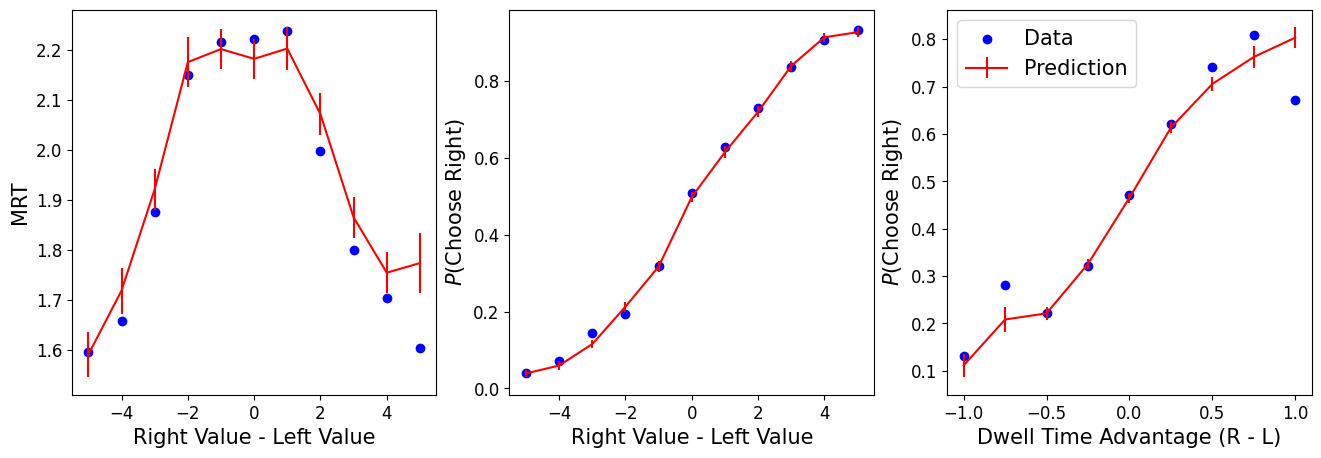

In [16]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1, c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1, 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

# plt.savefig('_plots/kr2010_complete_postpred.pdf', 
#             dpi=600, 
#             transparent=True, 
#             bbox_inches='tight');

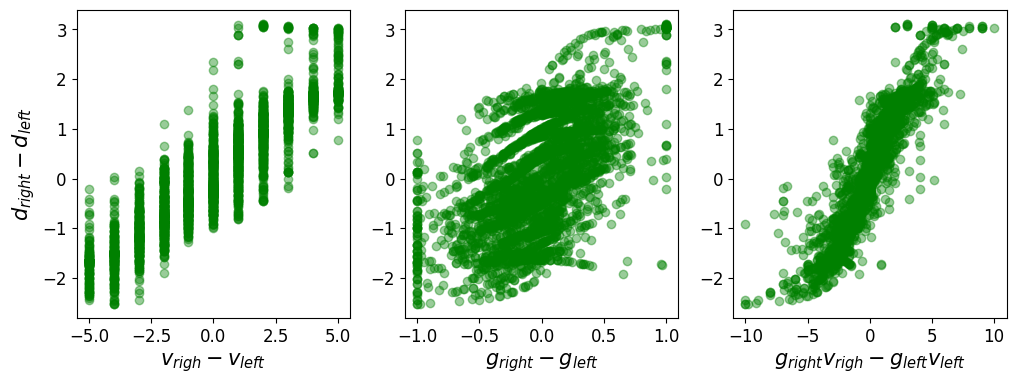

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

# plt.savefig('_plots/kr2010_complete_prmspred.pdf', 
#             dpi=600, 
#             transparent=True, 
#             bbox_inches='tight');

In [14]:
# est_gp = SymbolicRegressor(population_size=5000,
#                            function_set=['add', 'sub', 'mul', 'div'],
#                            generations=50, stopping_criteria=0.01,
#                            p_crossover=0.7, p_subtree_mutation=0.1,
#                            p_hoist_mutation=0.05, p_point_mutation=0.1,
#                            max_samples=0.9, verbose=1,
#                            parsimony_coefficient=0.01, random_state=0)
# est_gp.fit(X_train, pred_v[:, 0]-pred_v[:, 1])
# print(est_gp._program)